In [ ]:
%matplotlib inline

import pandas
import numpy
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics

warnings.filterwarnings("ignore")

In [ ]:
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

In [ ]:
print(train.head())

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal
4         0           tcp  ...                     0.00   normal

[5 rows x 42 columns]
Training data has 25192 rows & 42 columns


In [ ]:
print(test.head())

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                 1.00                     1.00
1         0           tcp  ...                 1.00                     1.00
2         2           tcp  ...                 0.00                     0.00
3         0          icmp  ...                 0.00                     0.00
4         1           tcp  ...                 0.83                     0.71

[5 rows x 41 columns]
Testing data has 22544 rows & 41 columns


In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


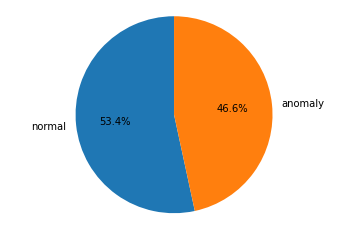

In [ ]:
ratio = train['class'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()

cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

sc_traindf = pandas.DataFrame(sc_train, columns = cols)
sc_testdf = pandas.DataFrame(sc_test, columns = cols)

In [ ]:
encoder = LabelEncoder()

cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [ ]:
train_x = pandas.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [ ]:
test_df = pandas.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

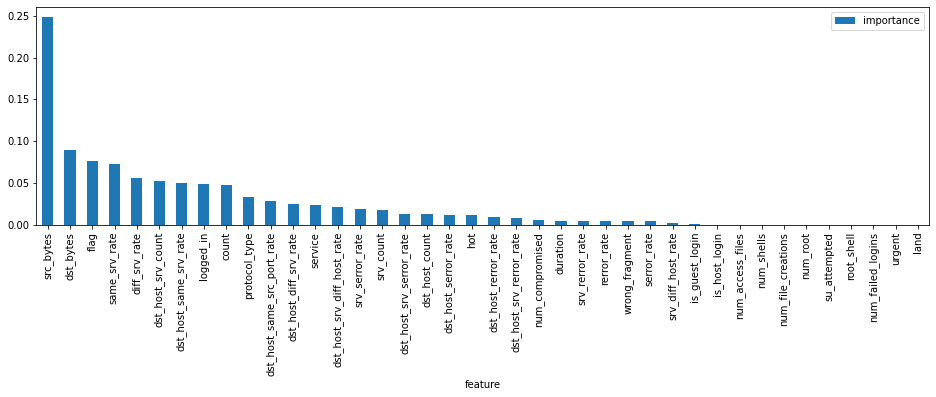

In [ ]:
rfc = RandomForestClassifier();

rfc.fit(train_x, train_y);

score = numpy.round(rfc.feature_importances_,3)
importances = pandas.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (16,4)
importances.plot.bar();

In [ ]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(train_x, train_y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

print(selected_features)

['src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'protocol_type', 'service', 'flag']


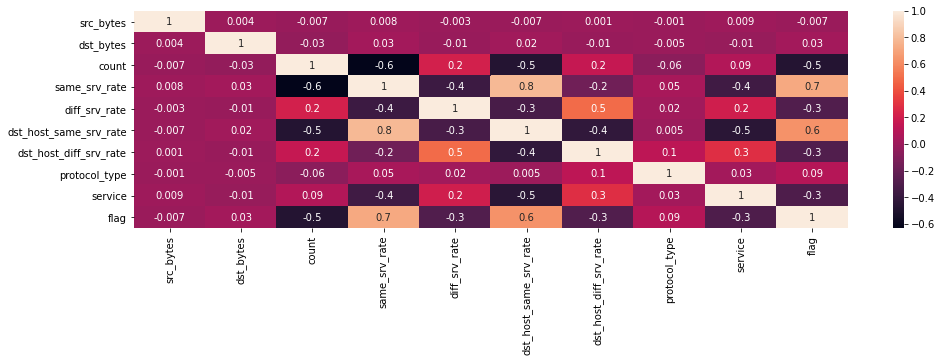

In [ ]:
seaborn.heatmap(train_x[selected_features].corr(), annot = True, fmt='.1g')

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.60, random_state=2)

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, Y_train); 

In [ ]:
scores = cross_val_score(model, X_train, Y_train, cv=10)
accuracy = metrics.accuracy_score(Y_train, model.predict(X_train))
confusion_matrix = metrics.confusion_matrix(Y_train, model.predict(X_train))
classification = metrics.classification_report(Y_train, model.predict(X_train))

print ("Cross Validation Mean Score:" "\n", scores.mean())
print ("Model Accuracy:" "\n", accuracy)
print ("Confusion matrix:" "\n", confusion_matrix)
print ("Classification report:" "\n", classification)

Cross Validation Mean Score:
 0.9910023145959611
Model Accuracy:
 0.9930532583526298
Confusion matrix:
 [[6984   70]
 [  35 8026]]
Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      0.99      0.99      7054
      normal       0.99      1.00      0.99      8061

    accuracy                           0.99     15115
   macro avg       0.99      0.99      0.99     15115
weighted avg       0.99      0.99      0.99     15115



In [ ]:
accuracy = metrics.accuracy_score(Y_test, model.predict(X_test))
confusion_matrix = metrics.confusion_matrix(Y_test, model.predict(X_test))
classification = metrics.classification_report(Y_test, model.predict(X_test))
                                                                     
print ("Model Accuracy:" "\n", accuracy)
print ("Confusion matrix:" "\n", confusion_matrix)
print ("Classification report:" "\n", classification)  

Model Accuracy:
 0.9904733551652277
Confusion matrix:
 [[4639   50]
 [  46 5342]]
Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      4689
      normal       0.99      0.99      0.99      5388

    accuracy                           0.99     10077
   macro avg       0.99      0.99      0.99     10077
weighted avg       0.99      0.99      0.99     10077



In [ ]:
prediction = model.predict(test_df)
test['prediction'] = prediction
print(test.head())

   duration protocol_type  ... dst_host_srv_rerror_rate prediction
0         0           tcp  ...                     1.00    anomaly
1         0           tcp  ...                     1.00    anomaly
2         2           tcp  ...                     0.00     normal
3         0          icmp  ...                     0.00    anomaly
4         1           tcp  ...                     0.71     normal

[5 rows x 41 columns]


In [ ]:
prediction

array(['anomaly', 'anomaly', 'normal', ..., 'anomaly', 'normal',
       'anomaly'], dtype=object)

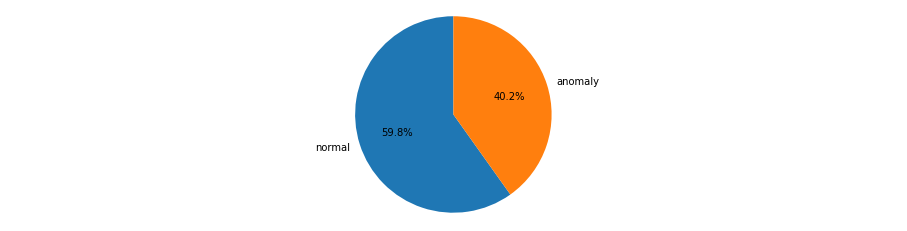

In [ ]:
ratio = test['prediction'].value_counts()
labels = ratio.index[0], ratio.index[1]
sizes = [ratio.values[0], ratio.values[1]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()